In [4]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import matplotlib 
import os
import yaml

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, os
import numpy as np
root = os.path.join(os.getcwd(), '../')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Distgen 
---

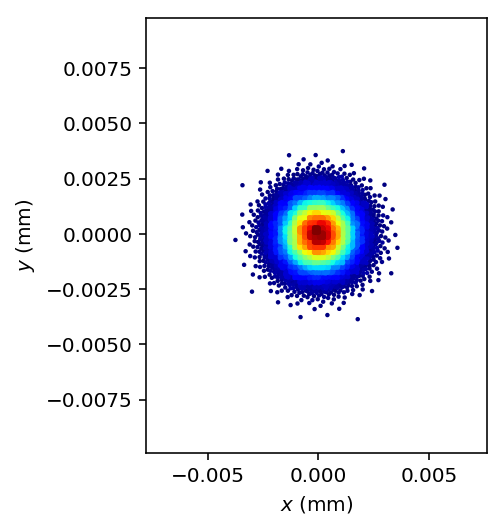

In [93]:
from distgen import Generator
from distgen.plot import plot_dist2d, plot_dist1d

DISTGEN_INPUT_FILE = os.path.join(root,'templates/tesla_9cell_cavity/distgen.in.yaml')
G = Generator(DISTGEN_INPUT_FILE)

beam = G.beam()

plot_dist2d(beam, 'x', 'mm', 'y', 'mm', axis='equal');

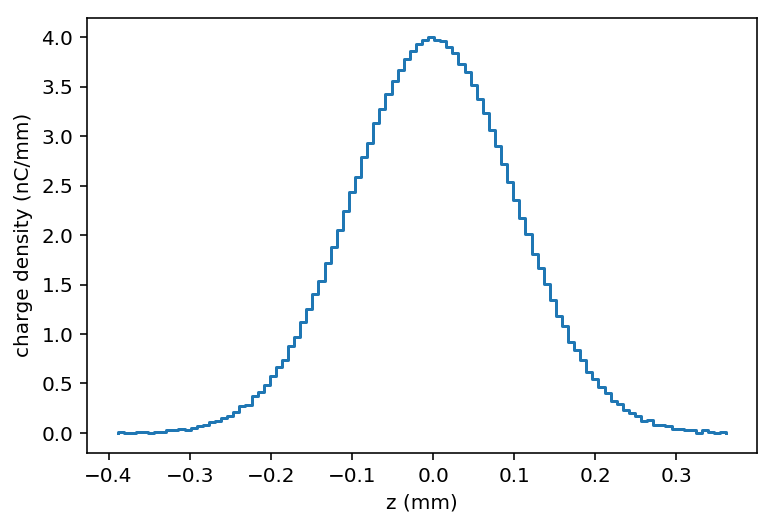

In [6]:
plot_dist1d(beam, 'z', 'mm')

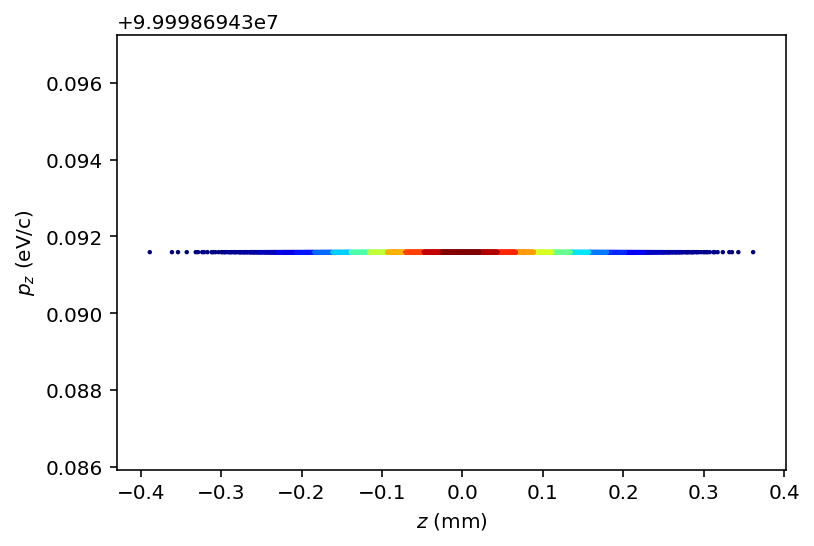

In [7]:
plot_dist2d(beam, 'z', 'mm', 'pz', 'eV/c');

# GPT input file:

In [8]:
GPT_INPUT_FILE = os.path.join(root,'templates/tesla_9cell_cavity/gpt.in')

# Run GPT without phasing
---

In [91]:
from gpt.gpt_distgen import run_gpt_with_distgen

settings={'n_particle':10000, 
          'Ntout':500,
          'field_scale':32000000.0,
          'space_charge':1}

G = run_gpt_with_distgen(settings,
                         gpt_input_file=GPT_INPUT_FILE,
                         distgen_input_file=DISTGEN_INPUT_FILE,
                         verbose=True,
                         gpt_verbose=False,
                         auto_phase=True)

print(G)

Run GPT with Distgen:
Replacing param n_particle with value 10000
Ntout is in gpt
field_scale is in gpt
space_charge is in gpt
Linking particle files, distgen output will point to -> "gpt.particles.gdf" in working directory.

Distgen >------

Distribution format: gpt
Output file: /var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpwos3anz4/gpt.particles.gdf

Creating beam distribution....
   Beam starting from: time
   Total charge: 1 nC.
   Number of macroparticles: 10000.
   Assuming cylindrical symmetry...
   r distribution: radial Gaussian
   theta distribution:       min_theta = 0 rad, max_theta = 6.28319 rad
   z distribution: Gaussian
      avg_z = 0 mm, sigma_z = 0.100 mm
   Shifting avg_x = -5.76994E-07 mm -> 0 mm
   Scaling sigma_x = 0.000998699 mm -> 0.001 mm
   Shifting avg_y = -1.45535E-07 mm -> 0 mm
   Scaling sigma_y = 0.000999866 mm -> 0.001 mm
   Shifting avg_z = -0.000131838 mm -> 0 mm
   Scaling sigma_z = 0.0999276 mm -> 0.1 mm
   Time start: fixing all particle time

In [68]:
avgz = G.stat('mean_z','tout')
avgKE = G.stat('mean_kinetic_energy','tout')
plt.plot(avgz, avgKE/1e6);

In [79]:
sigmaX = G.stat('sigma_x','tout')
plt.plot(avgz, sigmaX*1e6);
plt.xlabel('z (m)');
plt.ylabel('$\sigma_x$ ($\mu$m)');

In [82]:
enx = G.stat('norm_emit_x','tout')
plt.plot(avgz, enx*1e6);
plt.xlabel('z (m)');
plt.ylabel('$\epsilon_x$ ($\mu$m)');

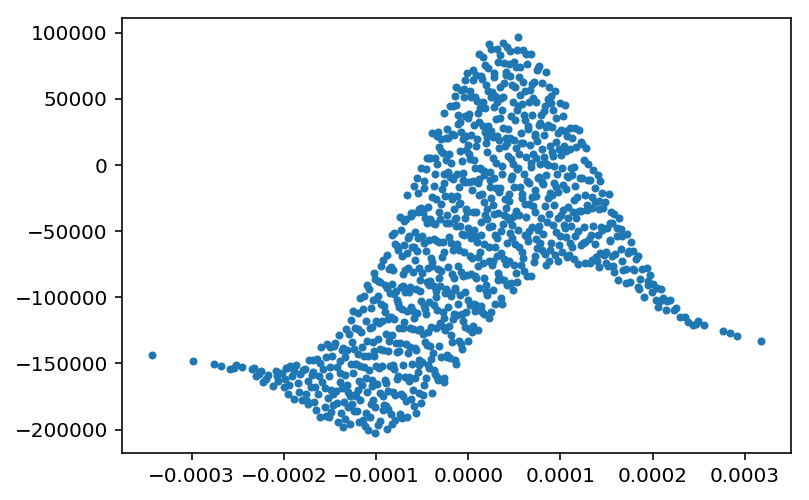

In [89]:
z_tout = 1.5

#fnp.where()



plt.plot(G.tout[-1]['delta_z'][::10], G.tout[-1]['delta_pz'][::10], '.')

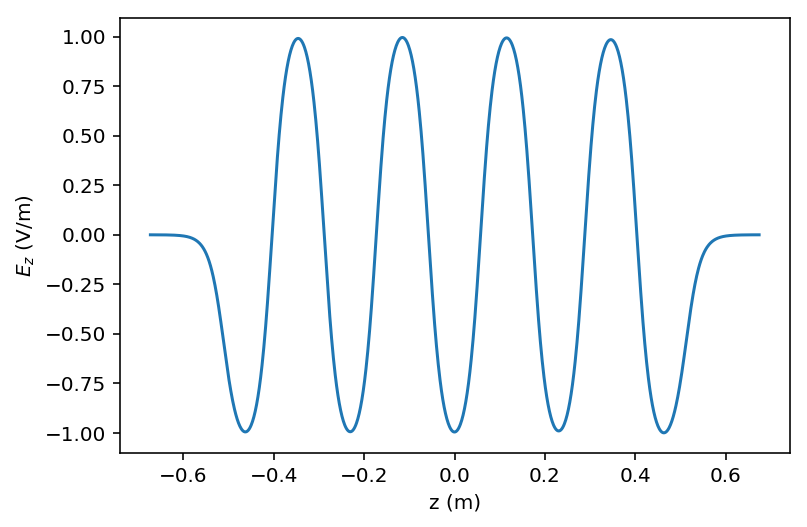

In [66]:
# Check the map:
data = np.loadtxt('../templates/tesla_9cell_cavity/tesla_9cell_cavity_for_gpt.txt', skiprows=1)

rs = data[:,0]
zs = data[:,1]
Er = data[:,2]
Ez = data[:,3]

z0 = zs[rs==0]
E0 = Ez[rs==0]

plt.plot(z0, E0)
plt.xlabel('z (m)')
plt.ylabel('$E_z$ (V/m)');

map1D = np.zeros( (len(z0),2) )
map1D[:,0] = z0
map1D[:,1] = E0

np.savetxt('../templates/tesla_9cell_cavity/tesla_9cell_1d.txt', map1D, delimiter=' ', header='z Ez')
